In [1]:
'''Este código tiene como objetivo crear un modelo de predicción de series temporales utilizando una red neuronal LSTM (Long Short-Term Memory).

Para ello, se comienza importando las librerías necesarias, como numpy, pandas y yfinance (para descargar los datos de cotización del índice DAX 30), y también se importan algunas funcionalidades de sklearn y keras para preprocesar los datos y crear el modelo de redes neuronales, respectivamente.

A continuación, se descargan los datos del índice DAX 30 desde el inicio del año 2000 hasta la fecha actual, y se dividen en dos conjuntos: uno para el entrenamiento del modelo y otro para validar su rendimiento. Luego, se normaliza el conjunto de entrenamiento utilizando la clase MinMaxScaler de sklearn.

A continuación, se crea la estructura de datos necesaria para entrenar el modelo, que consiste en una secuencia de 60 timesteps (o pasos en el tiempo) y una salida correspondiente al valor del índice en el siguiente timestep. Para ello, se recorre el conjunto de entrenamiento normalizado y se van guardando los arrays de 60 timesteps en X_train y las salidas correspondientes en y_train.

Luego, se reshapea X_train para que tenga la forma necesaria para ser utilizada por la red LSTM.

A continuación, se define la red LSTM con dos capas LSTM y una capa densa, y se compila utilizando el optimizador Adam y la función de pérdida mean squared error. Finalmente, se entrena el modelo con el conjunto de entrenamiento normalizado y las etiquetas correspondientes.

Una vez entrenado el modelo, se utiliza para hacer predicciones sobre el conjunto de prueba (que corresponde a los datos de cotización del índice DAX 30 desde 2019 hasta la fecha actual). Para ello, se normalizan los datos de prueba y se crea la estructura de datos necesaria para hacer la predicción, de manera similar a como se hizo con el conjunto de entrenamiento. Luego, se hacen las predicciones con el modelo entrenado y se desnormalizan utilizando el objeto MinMaxScaler utilizado previamente.

Finalmente, se grafican las predicciones junto con los valores reales del índice DAX 30, y se muestra el resultado en un gráfico.'''

'Este código tiene como objetivo crear un modelo de predicción de series temporales utilizando una red neuronal LSTM (Long Short-Term Memory).\n\nPara ello, se comienza importando las librerías necesarias, como numpy, pandas y yfinance (para descargar los datos de cotización del índice DAX 30), y también se importan algunas funcionalidades de sklearn y keras para preprocesar los datos y crear el modelo de redes neuronales, respectivamente.\n\nA continuación, se descargan los datos del índice DAX 30 desde el inicio del año 2000 hasta la fecha actual, y se dividen en dos conjuntos: uno para el entrenamiento del modelo y otro para validar su rendimiento. Luego, se normaliza el conjunto de entrenamiento utilizando la clase MinMaxScaler de sklearn.\n\nA continuación, se crea la estructura de datos necesaria para entrenar el modelo, que consiste en una secuencia de 60 timesteps (o pasos en el tiempo) y una salida correspondiente al valor del índice en el siguiente timestep. Para ello, se rec

In [2]:
#Importamos las librerías necesarias
import numpy as np
import pandas as pd

#Importamos yahoo finance para descargar los datos
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt


/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/parallels/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open 

In [3]:
dax30_data = yf.download("^GDAXI", start="2000-01-01",index_col = 'Date', parse_dates = ['Date'])
dax30_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00+01:00,6961.720215,7159.330078,6720.870117,6750.759766,6750.759766,43072500
2000-01-04 00:00:00+01:00,6747.240234,6755.359863,6510.459961,6586.950195,6586.950195,46678400
2000-01-05 00:00:00+01:00,6585.850098,6585.850098,6388.910156,6502.069824,6502.069824,52682800
2000-01-06 00:00:00+01:00,6501.450195,6539.310059,6402.629883,6474.919922,6474.919922,41180600
2000-01-07 00:00:00+01:00,6489.939941,6791.529785,6470.140137,6780.959961,6780.959961,56058900


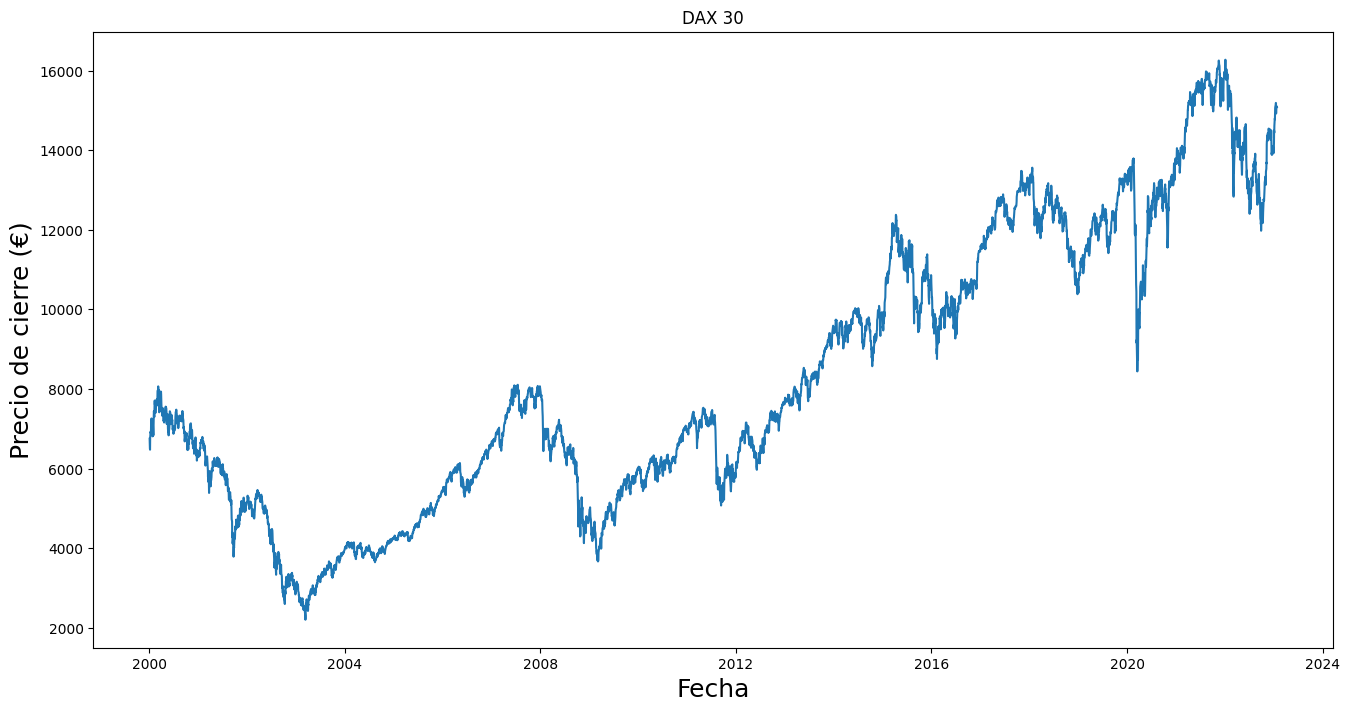

In [4]:
#Grafica del dax30
plt.figure(figsize=(16,8))
plt.title('DAX 30') 
plt.plot(dax30_data['Close'])
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio de cierre (€)',fontsize=18)
plt.show()

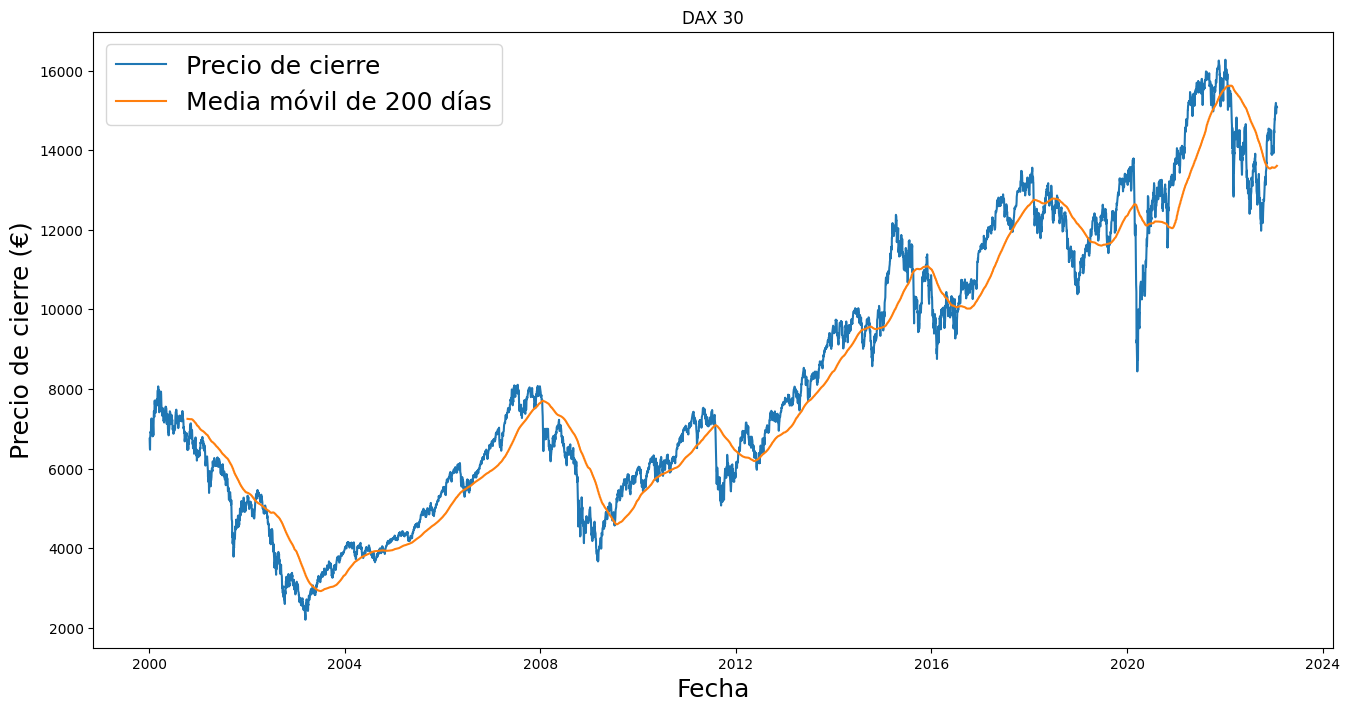

In [5]:
#Calculamos la media móvil de 200 días
dax30_data['SMA_200'] = dax30_data['Close'].rolling(window=200).mean()

#Grafica del dax30 con la media móvil de 200 días
plt.figure(figsize=(16,8))
plt.title('DAX 30')
plt.plot(dax30_data['Close'], label='Precio de cierre')
plt.plot(dax30_data['SMA_200'], label='Media móvil de 200 días')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio de cierre (€)',fontsize=18)
plt.legend(loc='upper left',fontsize=18)
plt.show()



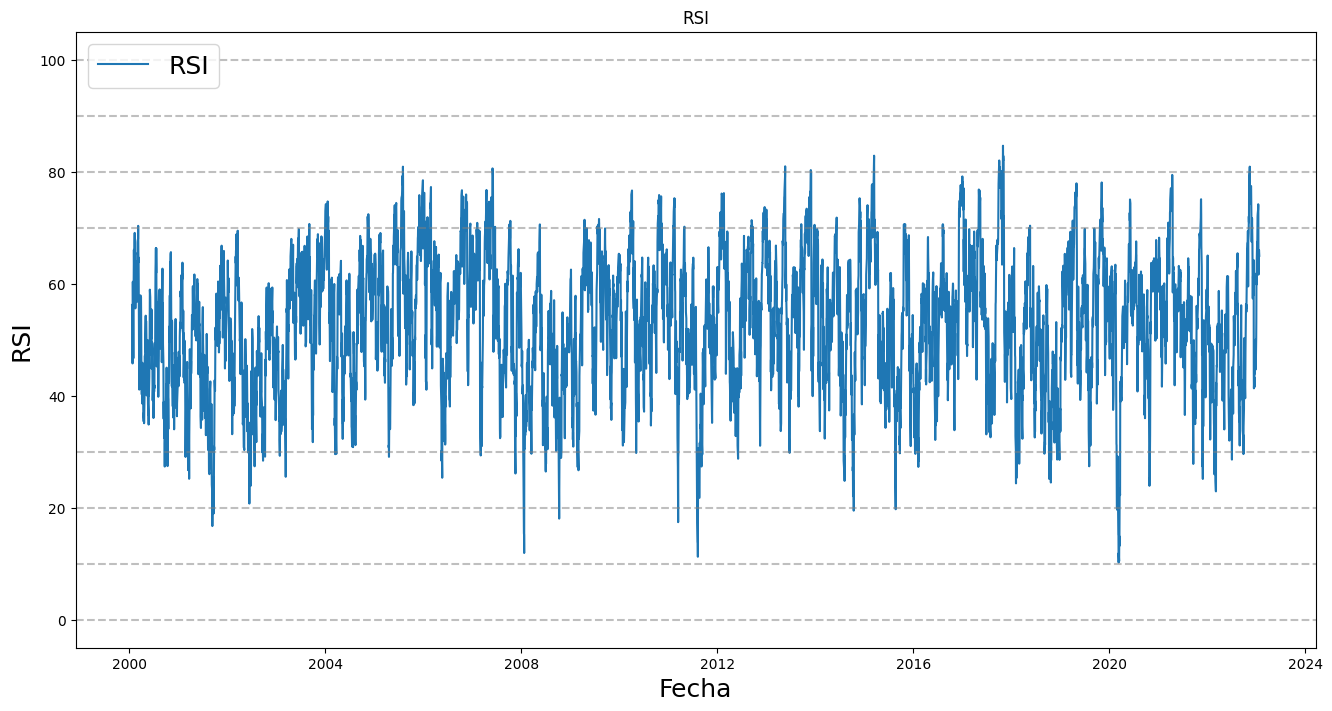

In [6]:
#Calculamos el RSI (Índice de fuerza relativa) con un periodo de 14 días
def RSI(data, time_window):
    diff = data.diff(1).dropna()        
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

dax30_data['RSI'] = RSI(dax30_data['Close'], 14)

#Grafica del RSI
plt.figure(figsize=(16,8))
plt.title('RSI')
plt.plot(dax30_data['RSI'], label='RSI')
plt.axhline(0, linestyle='--', alpha=0.5, color='gray')
plt.axhline(10, linestyle='--', alpha=0.5, color='gray')
plt.axhline(20, linestyle='--', alpha=0.5, color='gray')
plt.axhline(30, linestyle='--', alpha=0.5, color='gray')
plt.axhline(70, linestyle='--', alpha=0.5, color='gray')
plt.axhline(80, linestyle='--', alpha=0.5, color='gray')
plt.axhline(90, linestyle='--', alpha=0.5, color='gray')
plt.axhline(100, linestyle='--', alpha=0.5, color='gray')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('RSI',fontsize=18)
plt.legend(loc='upper left',fontsize=18)
plt.show()


In [7]:
'''OPERATIVA LARGO PLAZO PREDICCIÓN DEL PRECIO'''

'OPERATIVA LARGO PLAZO PREDICCIÓN DEL PRECIO'

In [8]:
#Dividimos el conjunto de Datos
set_entrenamiento = dax30_data[:'2019'].iloc[:,1:2]
set_prueba = dax30_data['2019':].iloc[:,1:2]


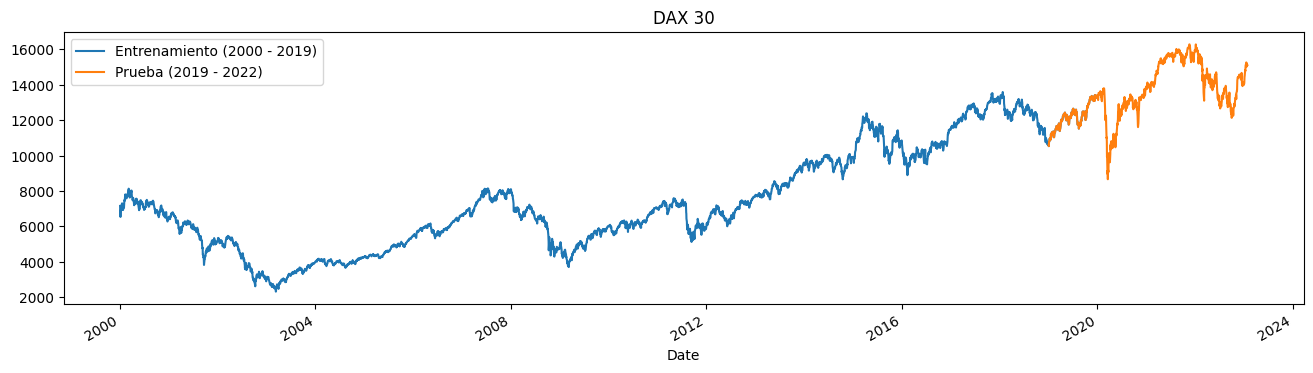

In [9]:
set_entrenamiento['High'].plot(figsize=(16,4),legend=True)
set_prueba['High'].plot(figsize=(16,4),legend=True)
plt.legend(['Entrenamiento (2000 - 2019)','Prueba (2019 - 2022)'])
plt.title('DAX 30')
plt.show()


In [10]:
#Normalizamos el set de entrenamiento
sc = MinMaxScaler(feature_range = (0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

#Creamos una estructura de datos con 60 timesteps y 1 salida
time_step = 60
X_train = []
y_train = []

m = len(set_entrenamiento_escalado)
for i in range(time_step,m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    y_train.append(set_entrenamiento_escalado[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))



In [11]:
#Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
neuronas = 100  # Aumenta el número de neuronas en la capa LSTM

modelo = Sequential()
modelo.add(LSTM(units=neuronas, input_shape=dim_entrada, return_sequences=True))  # Añade otra capa LSTM
modelo.add(LSTM(units=neuronas))  # Añade otra capa LSTM
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='adam', loss='mean_squared_error')# Utiliza el optimizador Adam
modelo.fit(X_train,y_train,epochs=20,batch_size=32)






Epoch 1/20
157/157 [==============================] - 15s 81ms/step - loss: 0.0055
Epoch 2/20
157/157 [==============================] - 13s 80ms/step - loss: 3.0687e-04
Epoch 3/20
157/157 [==============================] - 13s 81ms/step - loss: 2.8856e-04
Epoch 4/20
157/157 [==============================] - 13s 80ms/step - loss: 2.6283e-04
Epoch 5/20
157/157 [==============================] - 13s 80ms/step - loss: 2.5252e-04
Epoch 6/20
157/157 [==============================] - 13s 80ms/step - loss: 2.3107e-04
Epoch 7/20
157/157 [==============================] - 13s 80ms/step - loss: 2.4590e-04
Epoch 8/20
157/157 [==============================] - 13s 81ms/step - loss: 2.1684e-04
Epoch 9/20
157/157 [==============================] - 13s 81ms/step - loss: 2.2853e-04
Epoch 10/20
157/157 [==============================] - 13s 81ms/step - loss: 2.0309e-04
Epoch 11/20
157/157 [==============================] - 13s 81ms/step - loss: 1.7468e-04
Epoch 12/20
157/157 [========================

In [12]:
#Validacion(prediccion del valor del indice)

x_test = set_prueba.values
x_test = sc.transform(x_test)

X_test = []
m = len(x_test)
for i in range(time_step,m):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)








31/31 [==============================] - 1s 26ms/step


In [13]:
# Obtener valores reales del precio
precio_real = set_prueba.iloc[time_step:, :].values

# Crear un DataFrame con los valores de la predicción y los valores reales
df_prediccion = pd.DataFrame({'Predicción': prediccion.flatten(), 'Real': precio_real.flatten()})

# Añadir la columna 'Date' al DataFrame
df_prediccion['Date'] = set_prueba.index[time_step:]



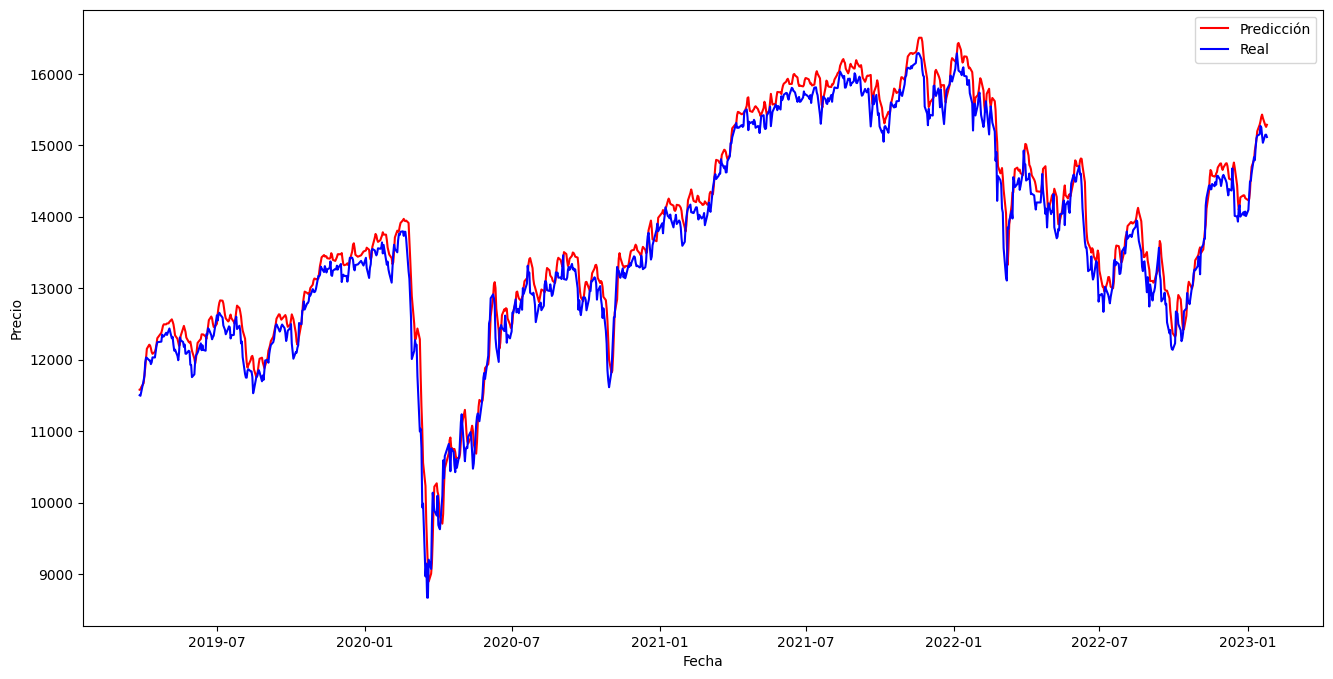

In [14]:
#Misma grafica pero mas grande
plt.figure(figsize=(16,8))
plt.plot(df_prediccion['Date'], df_prediccion['Predicción'], label='Predicción', c='red')
plt.plot(df_prediccion['Date'], df_prediccion['Real'], label='Real', c='blue')

plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()


In [15]:
# Crear un DataFrame con los valores de la predicción y los valores realesy extraer los primeros 5 valores
df_prediccion = pd.DataFrame({'Predicción': prediccion.flatten(), 'Real': precio_real.flatten()},
                              index=set_prueba.index[time_step:])[:5]

# Mostrar el DataFrame
df_prediccion


,Predicción,Real
Date,,
2019-03-27 00:00:00+01:00,11578.912109,11502.349609
2019-03-28 00:00:00+01:00,11581.584961,11494.150391
2019-03-29 00:00:00+01:00,11615.033203,11549.419922
2019-04-01 00:00:00+02:00,11669.997070,11706.639648
2019-04-02 00:00:00+02:00,11774.977539,11777.650391
...,...,...
2023-01-19 00:00:00+01:00,15428.522461,15134.070312
2023-01-20 00:00:00+01:00,15381.514648,15034.429688
2023-01-23 00:00:00+01:00,15278.510742,15145.900391


In [16]:
#Metemos la media movil de 200 dias en un conjunto de datos
dax30_data['SMA200'] = dax30_data['Close'].rolling(window=200).mean()



In [17]:

#Imports necesarios para exportar un archivo csv y después representarlo en Power BI
#Añadir en df_prediccion la media movil de 200 dias en una nueva columna
df_prediccion['SMA200'] = dax30_data['SMA200'].iloc[-len(df_prediccion):]

#Añadir en df_prediccion el rsi de 14 dias en una nueva columna
df_prediccion['RSI'] = dax30_data['RSI'].iloc[-len(df_prediccion):]

#Añadir en df_prediccion el volumen en una nueva columna
df_prediccion['Volume'] = dax30_data['Volume'].iloc[-len(df_prediccion):]

#Añadimos una nueva columna en df_prediccion que resta el valor de ayer menos el valor de hoy y hace el porcentaje de la resta y lo multiplica por 100 y la columna se llamará Variación
df_prediccion['Variación'] = ((df_prediccion['Real'] - df_prediccion['Real'].shift(1)) / df_prediccion['Real'].shift(1)) * 100

#Creo una condicion en el excel de la columna Date para quedarme con los 10 primeros caracteres

df_prediccion['Fecha'] = df_prediccion.index
#Me quedo con los 10 primeros caracteres de la columna Date
df_prediccion['Fecha'] = df_prediccion['Fecha'].astype(str).str[:10]

In [18]:
df_prediccion

,Predicción,Real,SMA200,RSI,Volume,Variación,Fecha
Date,,,,,,,
2019-03-27 00:00:00+01:00,11578.912109,11502.349609,11738.359009,47.359185,102107000,NaN,2019-03-27
2019-03-28 00:00:00+01:00,11581.584961,11494.150391,11731.046909,47.895728,89405300,-0.071283,2019-03-28
2019-03-29 00:00:00+01:00,11615.033203,11549.419922,11723.141611,53.386934,89325500,0.480849,2019-03-29
2019-04-01 00:00:00+02:00,11669.997070,11706.639648,11716.498813,60.525182,96979200,1.361278,2019-04-01
2019-04-02 00:00:00+02:00,11774.977539,11777.650391,11711.102212,63.346961,77384300,0.606585,2019-04-02
...,...,...,...,...,...,...,...
2023-01-19 00:00:00+01:00,15428.522461,15134.070312,13586.916655,61.622160,64167400,-0.762540,2023-01-19
2023-01-20 00:00:00+01:00,15381.514648,15034.429688,13591.459702,64.384119,64031100,-0.658386,2023-01-20
2023-01-23 00:00:00+01:00,15278.510742,15145.900391,13596.592251,65.999461,39903900,0.741436,2023-01-23


In [36]:
#Descargamos los datos de la prediccion en un archivo csv
df_prediccion.to_csv('dax30_Junio_2023.csv')

In [20]:
#Ahora hacemos lo mismo para los distintos indices bursátiles 
#España nasdaq100

nasdaq100_data = yf.download('^NDX',start="2000-01-01",index_col = 'Date', parse_dates = ['Date'])
nasdaq100_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-05:00,3755.739990,3836.860107,3643.25000,3790.550049,3790.550049,1510070000
2000-01-04 00:00:00-05:00,3766.570068,3766.570068,3542.72998,3546.199951,3546.199951,1511840000
2000-01-05 00:00:00-05:00,3543.129883,3576.169922,3371.75000,3507.310059,3507.310059,1735670000
2000-01-06 00:00:00-05:00,3488.310059,3513.550049,3334.02002,3340.810059,3340.810059,1598320000
2000-01-07 00:00:00-05:00,3337.260010,3529.750000,3314.75000,3529.600098,3529.600098,1634930000


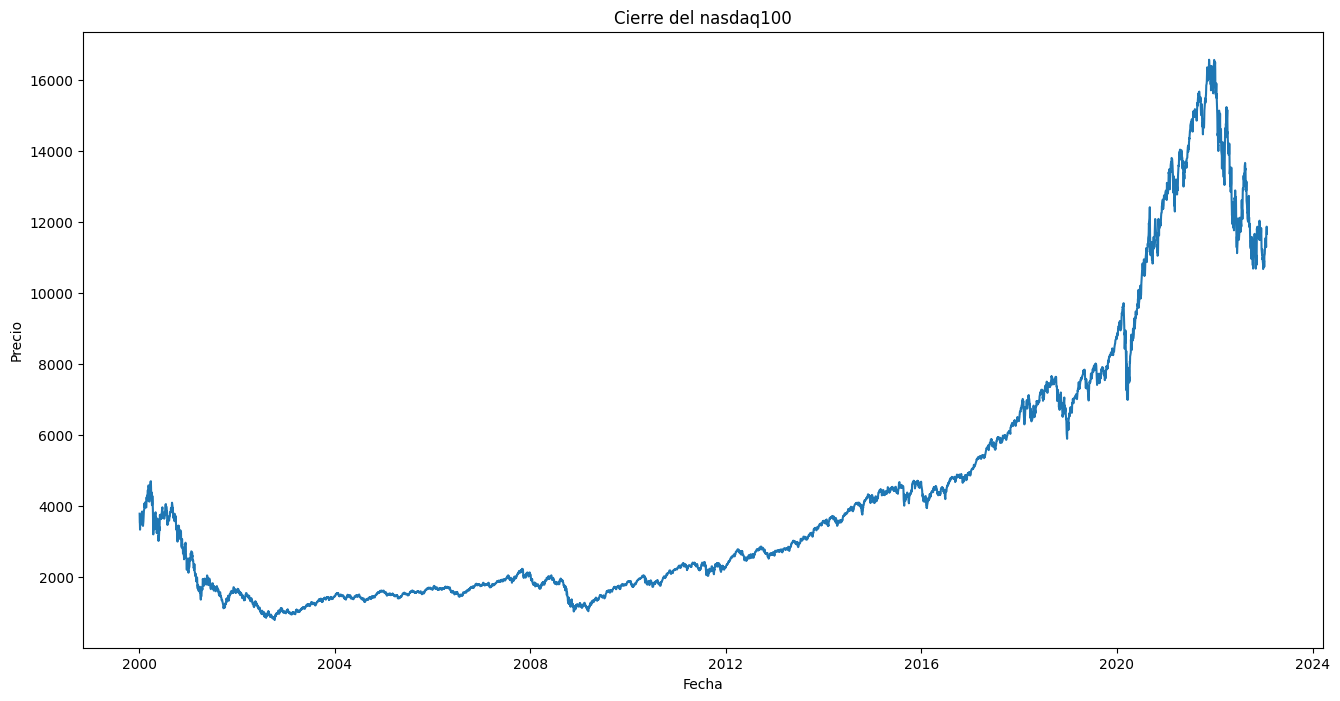

In [21]:
#Grafica del nasdaq100
plt.figure(figsize=(16,8))
plt.title('Cierre del nasdaq100')
plt.plot(nasdaq100_data['Close'])
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()




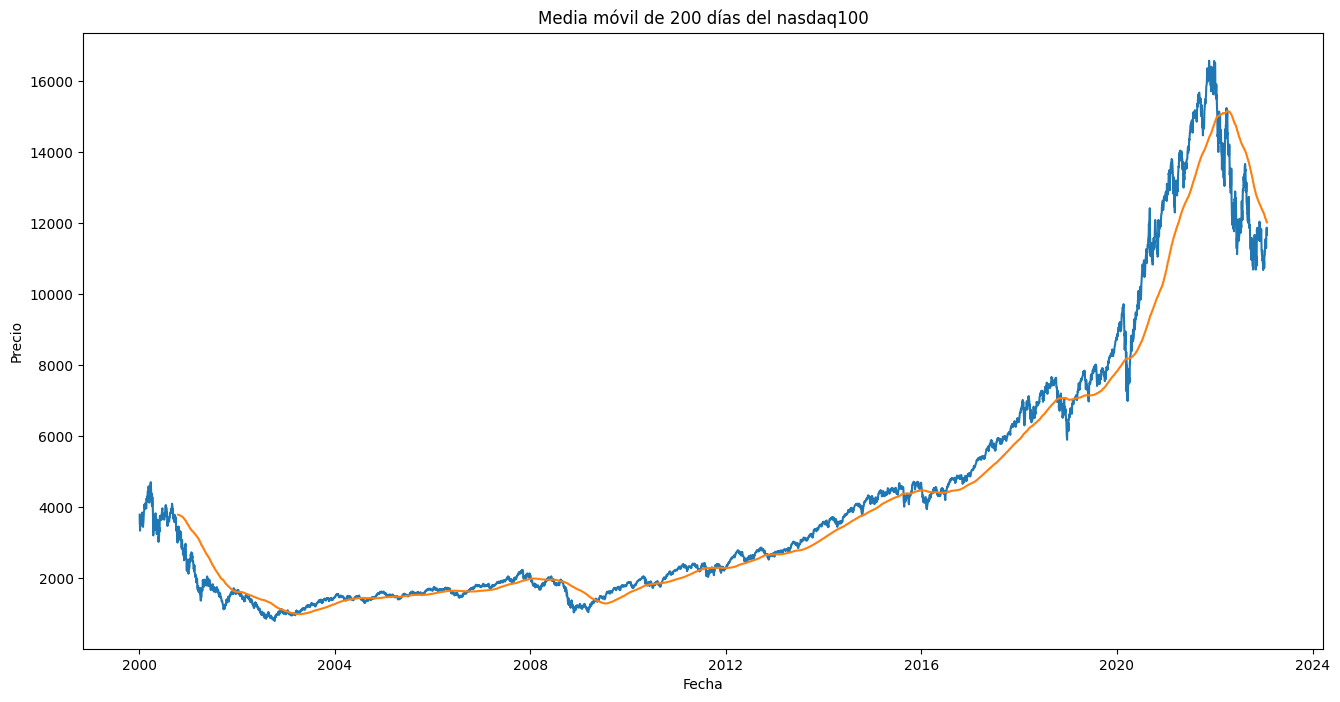

In [22]:
#Calculamos la media móvil de 200 días del nasdaq100
nasdaq100_data['SMA200'] = nasdaq100_data['Close'].rolling(window=200).mean()

#Grafica de la media movil de 200 dias del nasdaq100
plt.figure(figsize=(16,8))
plt.title('Media móvil de 200 días del nasdaq100')
plt.plot(nasdaq100_data['Close'])
plt.plot(nasdaq100_data['SMA200'])
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()


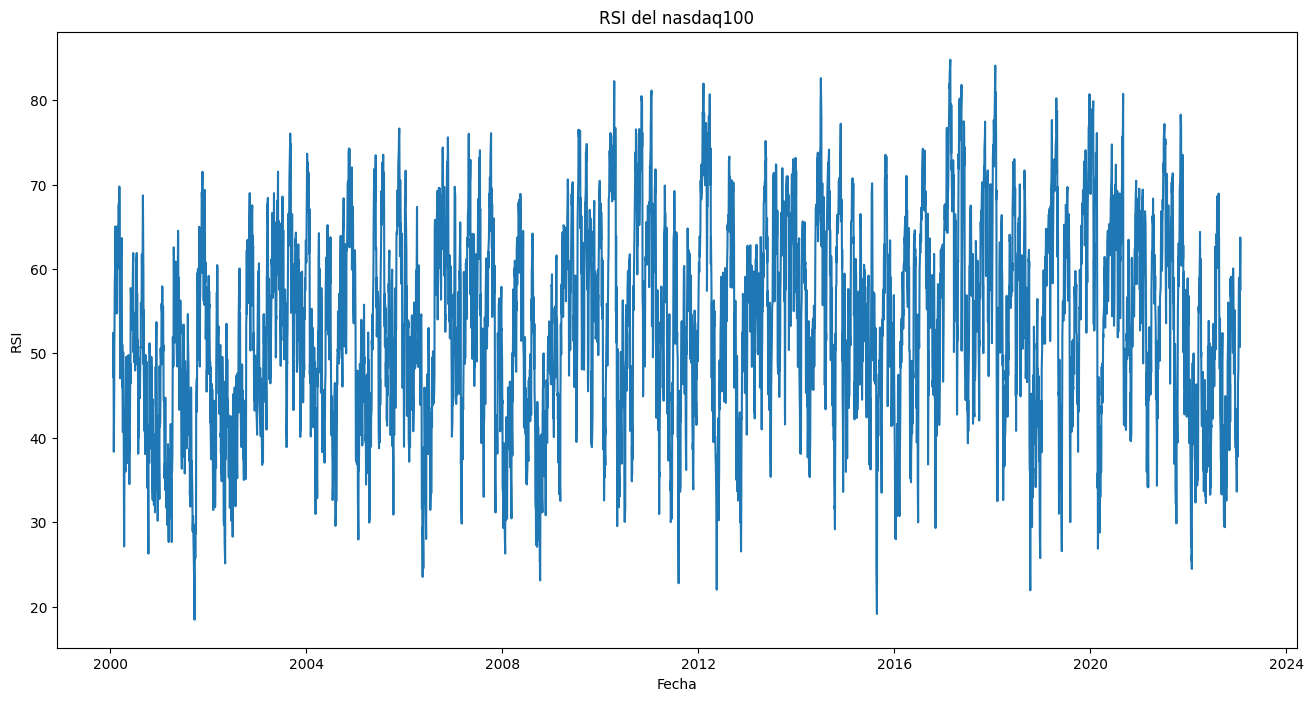

In [23]:
#RSI del nasdaq100
nasdaq100_data['RSI'] = RSI(nasdaq100_data['Close'], 14)

#Grafica del RSI del nasdaq100
plt.figure(figsize=(16,8))
plt.title('RSI del nasdaq100')
plt.plot(nasdaq100_data['RSI'])
plt.xlabel('Fecha')
plt.ylabel('RSI')
plt.show()


In [24]:
#Dividimos el conjunto de Datos del nasdaq100 en dos conjuntos de datos, uno de entrenamiento y otro de prueba
set_entrenamiento = nasdaq100_data[:'2019'].iloc[:,1:2]
set_prueba = nasdaq100_data['2019':].iloc[:,1:2]


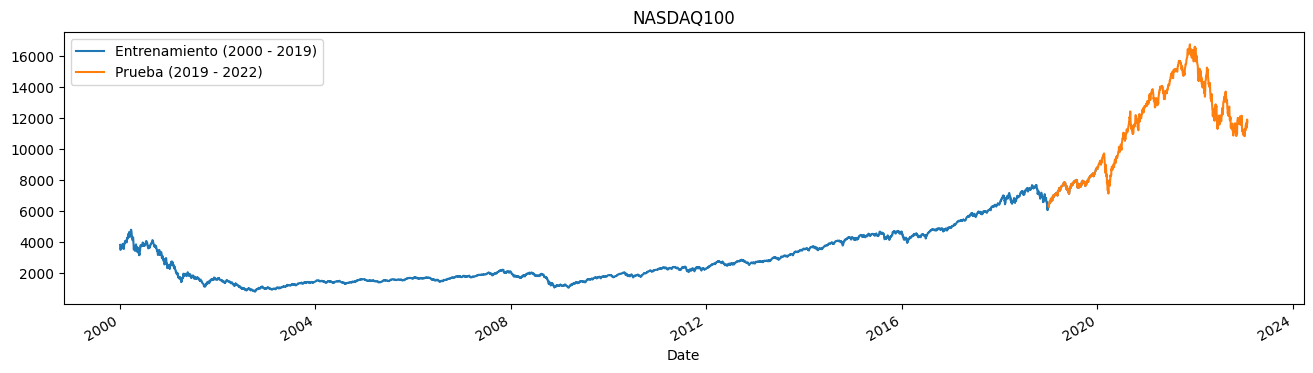

In [25]:
set_entrenamiento['High'].plot(figsize=(16,4),legend=True)
set_prueba['High'].plot(figsize=(16,4),legend=True)
plt.legend(['Entrenamiento (2000 - 2019)','Prueba (2019 - 2022)'])
plt.title('NASDAQ100')
plt.show()


In [26]:
#Normalizamos el set de entrenamiento
sc = MinMaxScaler(feature_range = (0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

#Creamos una estructura de datos con 60 timesteps y 1 salida
time_step = 60
X_train = []
y_train = []

m = len(set_entrenamiento_escalado)
for i in range(time_step,m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    y_train.append(set_entrenamiento_escalado[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))



In [27]:
#Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
neuronas = 100  # Aumenta el número de neuronas en la capa LSTM

modelo = Sequential()
modelo.add(LSTM(units=neuronas, input_shape=dim_entrada, return_sequences=True))  # Añade otra capa LSTM
modelo.add(LSTM(units=neuronas))  # Añade otra capa LSTM
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='adam', loss='mean_squared_error')# Utiliza el optimizador Adam
modelo.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
156/156 [==============================] - 16s 86ms/step - loss: 0.0028
Epoch 2/20
156/156 [==============================] - 14s 90ms/step - loss: 1.2402e-04
Epoch 3/20
156/156 [==============================] - 14s 88ms/step - loss: 1.2107e-04
Epoch 4/20
156/156 [==============================] - 14s 87ms/step - loss: 1.2683e-04
Epoch 5/20
156/156 [==============================] - 13s 86ms/step - loss: 1.1944e-04
Epoch 6/20
156/156 [==============================] - 13s 84ms/step - loss: 1.2546e-04
Epoch 7/20
156/156 [==============================] - 14s 87ms/step - loss: 1.1159e-04
Epoch 8/20
156/156 [==============================] - 19s 121ms/step - loss: 1.1376e-04
Epoch 9/20
156/156 [==============================] - 14s 89ms/step - loss: 9.8474e-05
Epoch 10/20
156/156 [==============================] - 15s 94ms/step - loss: 1.0740e-04
Epoch 11/20
156/156 [==============================] - 17s 107ms/step - loss: 9.4112e-05
Epoch 12/20
156/156 [======================

In [28]:
#Validacion(prediccion del valor del indice)

x_test = set_prueba.values
x_test = sc.transform(x_test)

X_test = []
m = len(x_test)
for i in range(time_step,m):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


31/31 [==============================] - 2s 26ms/step


In [29]:
# Obtener valores reales del precio
precio_real = set_prueba.iloc[time_step:, :].values

# Crear un DataFrame con los valores de la predicción y los valores reales
df_prediccion_nasdaq100 = pd.DataFrame({'Predicción': prediccion.flatten(), 'Real': precio_real.flatten()})

# Añadir la columna 'Date' al DataFrame
df_prediccion_nasdaq100['Date'] = set_prueba.index[time_step:]

In [30]:
df_prediccion_nasdaq100

,Predicción,Real,Date
0,7218.850098,7381.689941,2019-03-29 00:00:00-04:00
1,7209.934082,7481.839844,2019-04-01 00:00:00-04:00
2,7242.868652,7507.049805,2019-04-02 00:00:00-04:00
3,7291.111816,7589.689941,2019-04-03 00:00:00-04:00
4,7357.313965,7571.129883,2019-04-04 00:00:00-04:00
...,...,...,...
959,11365.785156,11388.459961,2023-01-19 00:00:00-05:00
960,11282.047852,11623.200195,2023-01-20 00:00:00-05:00
961,11260.024414,11918.860352,2023-01-23 00:00:00-05:00
962,11375.186523,11889.370117,2023-01-24 00:00:00-05:00


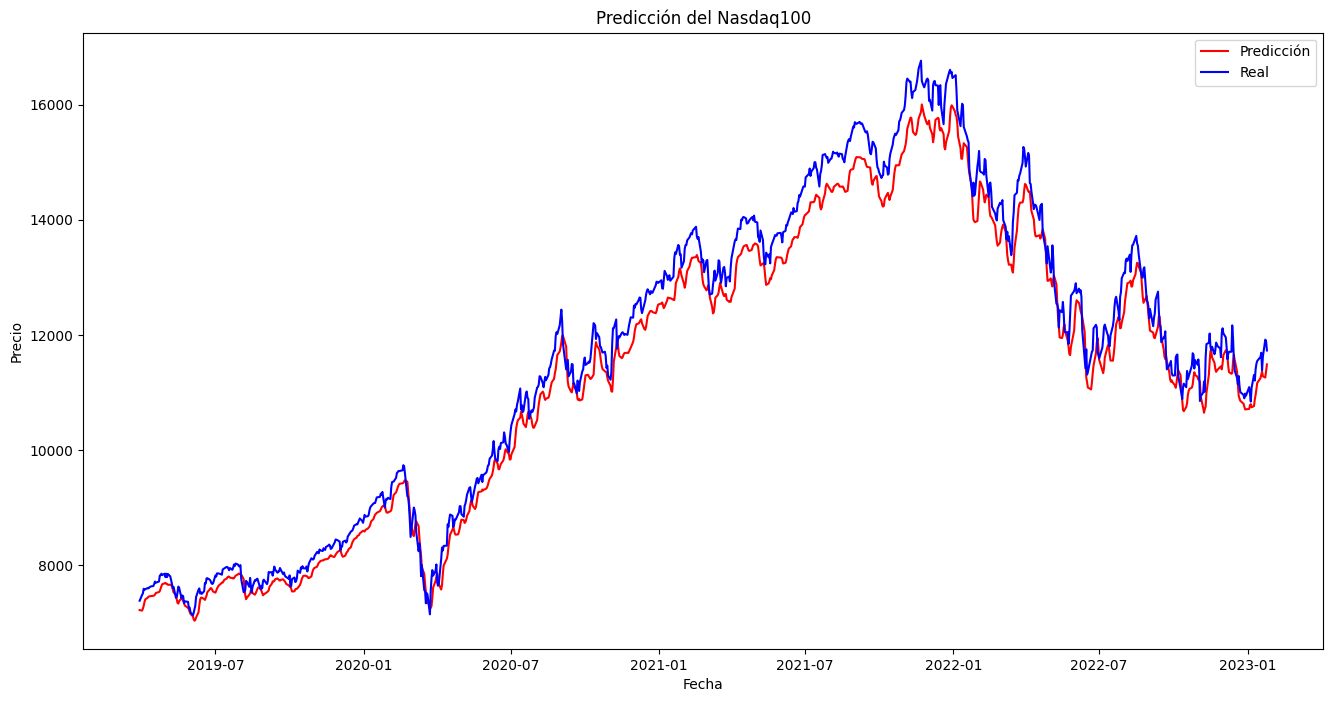

In [31]:
#Misma grafica pero mas grande
plt.figure(figsize=(16,8))
plt.plot(df_prediccion_nasdaq100['Date'], df_prediccion_nasdaq100['Predicción'], label='Predicción', c='red')
plt.plot(df_prediccion_nasdaq100['Date'], df_prediccion_nasdaq100['Real'], label='Real', c='blue')
#titulo de la grafica
plt.title('Predicción del Nasdaq100')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()


In [32]:
df_prediccion_nasdaq100

,Predicción,Real,Date
0,7218.850098,7381.689941,2019-03-29 00:00:00-04:00
1,7209.934082,7481.839844,2019-04-01 00:00:00-04:00
2,7242.868652,7507.049805,2019-04-02 00:00:00-04:00
3,7291.111816,7589.689941,2019-04-03 00:00:00-04:00
4,7357.313965,7571.129883,2019-04-04 00:00:00-04:00
...,...,...,...
959,11365.785156,11388.459961,2023-01-19 00:00:00-05:00
960,11282.047852,11623.200195,2023-01-20 00:00:00-05:00
961,11260.024414,11918.860352,2023-01-23 00:00:00-05:00
962,11375.186523,11889.370117,2023-01-24 00:00:00-05:00


In [33]:

#Imports necesarios para exportar un archivo csv
#Añadir en df_prediccion la media movil de 200 dias en una nueva columna
df_prediccion_nasdaq100['SMA200'] = nasdaq100_data['SMA200'].iloc[-len(df_prediccion_nasdaq100):]

#Añadir en df_prediccion el rsi de 14 dias en una nueva columna
df_prediccion_nasdaq100['RSI'] = nasdaq100_data['RSI'].iloc[-len(df_prediccion_nasdaq100):]

#Añadir en df_prediccion el volumen en una nueva columna
df_prediccion_nasdaq100['Volume'] = nasdaq100_data['Volume'].iloc[-len(df_prediccion_nasdaq100):]

#Añadimos una nueva columna en df_prediccion que resta el valor de ayer menos el valor de hoy y hace el porcentaje de la resta y lo multiplica por 100 y la columna se llamará Variación
df_prediccion_nasdaq100['Variación'] = ((df_prediccion_nasdaq100['Real'] - df_prediccion_nasdaq100['Real'].shift(1)) / df_prediccion_nasdaq100['Real'].shift(1)) * 100

#Creo una condicion en el excel de la columna Date para quedarme con los 10 primeros caracteres

df_prediccion_nasdaq100['Fecha'] = df_prediccion_nasdaq100.index
#Me quedo con los 10 primeros caracteres de la columna Date
df_prediccion_nasdaq100['Fecha'] = df_prediccion_nasdaq100['Date'].astype(str).str[:10]

In [34]:
df_prediccion_nasdaq100
#Exportar a csv
df_prediccion_nasdaq100.to_csv('nasdaq100_Junio_2023.csv', index=False)